# Exploration of tabular interpretable representations

In [1]:
! mkdir -p _figures

In [2]:
# NBVAL_IGNORE_OUTPUT
import fatf
import sklearn.preprocessing
import sklearn.datasets

import numpy as np

from sklearn import ensemble

from helpers import plot_bar_exp

In [3]:
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

plt.style.use('seaborn')

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
matplotlib.rc('text', usetex=True)

%matplotlib inline

In [4]:
RANDOM_SEED = 42

## Toy Examples ##

### Define Tabular Data and Model Decision Surface ###

In [5]:
X = np.array([
    # red
    [0, 3],
    [0, 2],
    [1, 3],
    [1, 2],
    [2, 3],
    [2, 2],
    [2, 1],
    [2, 0],
    [3, 1],
    [3, 0],
    [4, 1],
    [4, 0],
    # green
    [0, 1],
    [0, 0],
    [1, 1],
    [1, 0],
    [3, 3],
    [3, 2],
    [4, 3],
    [4, 2],
    [5, 3],
    [5, 2],
    [5, 1],
    [5, 0]
]) + 0.5

y = np.array(12 * ['r'] + 12 * ['g'])
y_num = np.array(12 * [0] + 12 * [1])

In [6]:
# generate data
size_ = 1000
scale_1 = [.45, .45]
size = (size_, 2)

fatf.setup_random_seed(RANDOM_SEED)
rand = [
    np.random.normal([1, 3], scale_1, size),
    np.random.normal([2.5, 2], [.5, 2], size),
    np.random.normal([4, 1], scale_1, size),
    #
    np.random.normal([1, 1], scale_1, size),
    np.random.normal([5.5, 2], [.5, 2], size),
    np.random.normal([4, 3], scale_1, size)
]
rand = np.concatenate(rand)

rand_y = ((size_ * [0]) + (size_ * [0]) + (size_ * [0])
          + (size_ * [1]) + (size_ * [1]) + (size_ * [1]))

# fit black box
bb_clf = ensemble.RandomForestClassifier(
  n_estimators=50, random_state=RANDOM_SEED)
bb_clf.fit(rand, rand_y)  # X, y_num

# predict data
plot_class_probs = 0

x_min, x_max = 0, 6
x_range = x_max - x_min

y_min, y_max = 0, 4
y_range = y_max - y_min

padding = 0.0

x_min -= x_range * padding
x_max += x_range * padding

y_min -= y_range * padding
y_max += y_range * padding

grid_step = 0.01
grid_xx, grid_yy = np.meshgrid(
    np.arange(x_min, x_max, grid_step),
    np.arange(y_min, y_max, grid_step))

grid_prediction = bb_clf.predict_proba(
    np.c_[grid_xx.ravel(), grid_yy.ravel()])
# get probabilities of the selected class
grid_prediction = grid_prediction[:, plot_class_probs]
grid_prediction = grid_prediction.reshape(grid_xx.shape)

grid_prediction = np.around(grid_prediction, decimals=1)

# lt5 = grid_prediction < 0.7
# gt5 = grid_prediction >= 0.7

# grid_prediction[lt5] = 0
# grid_prediction[gt5] = 1

22-May-07 16:14:46 fatf         INFO     Seeding RNGs using the input parameter.
22-May-07 16:14:46 fatf         INFO     Seeding RNGs with 42.


### Discretisation ###

#### Distribution-aware ####

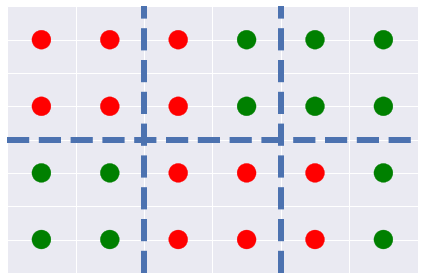

In [7]:
plt.figure(figsize=(6, 4))

plt.scatter(X[:, 0], X[:, 1], c=y, s=360)
plt.xlim([0, 6])
plt.ylim([0, 4])

# y
_line = plt.plot([0, 6], [2, 2], linewidth=6, linestyle='--')
_line_colour = _line[0].get_color()

# x
plt.plot([2, 2], [0, 4], linewidth=6, linestyle='--', c=_line_colour)
plt.plot([4, 4], [0, 4], linewidth=6, linestyle='--', c=_line_colour)

plt.tick_params(axis='both',
                which='both',
                bottom=False,
                labelbottom=False,
                left=False,
                labelleft=False)

plt.tight_layout()
plt.savefig('_figures/discretisation_dist_raw.pdf',
            dpi=300, bbox_inches='tight')

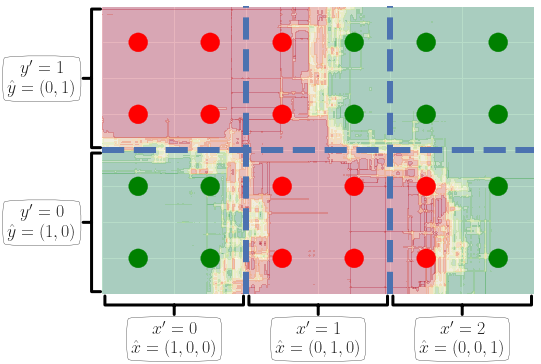

In [8]:
fig = plt.figure()  # figsize=(6, 4) # (7, 4)
ax = fig.add_axes((0, 0, 1, 1))

# plot
cs = plt.contourf(grid_xx, grid_yy, grid_prediction,
                  vmin=0, vmax=1, alpha=0.3,
                  cmap=plt.cm.RdYlGn.reversed())  # Spectral
# cbar = plt.colorbar(cs, ticks=[0, .2, .4, .6, .8, 1])

# plt.pcolormesh(grid_xx, grid_yy, grid_prediction)
#                cmap=plt.cm.Spectral)

plt.scatter(X[:, 0], X[:, 1], c=y, s=360)

# y
_line = plt.plot([0, 6], [2, 2], linewidth=6, linestyle='--')
_line_colour = _line[0].get_color()

# x
plt.plot([2, 2], [0, 4], linewidth=6, linestyle='--', c=_line_colour)
plt.plot([4, 4], [0, 4], linewidth=6, linestyle='--', c=_line_colour)

plt.xlim([0, 6])
plt.ylim([0, 4])

plt.tick_params(axis='both',
                which='both',
                bottom=False,
                labelbottom=False,
                left=False,
                labelleft=False)

# annotation
assert len(fig.axes) == 1
ax = fig.axes[0]
fontsize = 12
anot_x = '''\(x^\prime={xp:d}\)\n\(\hat{{x}}=({xh1:d},{xh2:d},{xh3:d})\)'''
anot_y = '''\(y^\prime={yp:d}\)\n\(\hat{{y}}=({yh1:d},{yh2:d})\)'''
params = dict(
    xycoords='axes fraction', 
    fontsize=fontsize * 1.5,
    ma='center',
    bbox=dict(boxstyle='round4', fc='white', ec='black'),
    arrowprops=dict(arrowstyle='-[, widthB=3.85, lengthB=.5', lw=3.0)
)
params_x = dict(
    ha='center',
    va='top'
)
params_y = dict(
    ha='right',
    va='center'
)

# x-axis
ax.annotate(anot_x.format(xp=0, xh1=1, xh2=0, xh3=0),
            xy=(1 / 6, 0 - (.02 * 3 / 2)),
            xytext=(1 / 6, 0 - (.06 * 3 / 2)),
            **params, **params_x)
ax.annotate(anot_x.format(xp=1, xh1=0, xh2=1, xh3=0),
            xy=(3 / 6, 0 - (.02 * 3 / 2)),
            xytext=(3 / 6, 0 - (.06 * 3 / 2)),
            **params, **params_x)
ax.annotate(anot_x.format(xp=2, xh1=0, xh2=0, xh3=1),
            xy=(5 / 6, 0 - (.02 * 3 / 2)),
            xytext=(5 / 6, 0 - (.06 * 3 / 2)),
            **params, **params_x)

# y-axis
ax.annotate(anot_y.format(yp=0, yh1=1, yh2=0),
            xy=(-0.02, 1 / 4),
            xytext=(-.06, 1 / 4),
            **params, **params_y)
ax.annotate(anot_y.format(yp=1, yh1=0, yh2=1),
            xy=(-0.02, 3 / 4),
            xytext=(-.06, 3 / 4),
            **params, **params_y)

# plt.tight_layout()
plt.savefig('_figures/discretisation_dist_annotated.pdf',
            transparent=True, dpi=300, bbox_inches='tight')

#### (Black-box) Class-aware ####

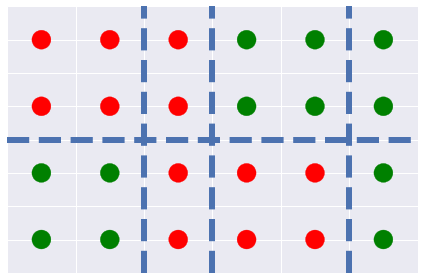

In [9]:
plt.figure(figsize=(6, 4))

plt.scatter(X[:, 0], X[:, 1], c=y, s=360)
plt.xlim([0, 6])
plt.ylim([0, 4])

# y
_line = plt.plot([0, 6], [2, 2], linewidth=6, linestyle='--')
_line_colour = _line[0].get_color()

# x
plt.plot([2, 2], [0, 4], linewidth=6, linestyle='--', c=_line_colour)
plt.plot([3, 3], [0, 4], linewidth=6, linestyle='--', c=_line_colour)
plt.plot([5, 5], [0, 4], linewidth=6, linestyle='--', c=_line_colour)

plt.tick_params(axis='both',
                which='both',
                bottom=False,
                labelbottom=False,
                left=False,
                labelleft=False)

plt.tight_layout()
plt.savefig('_figures/discretisation_class_raw.pdf',
            dpi=300, bbox_inches='tight')

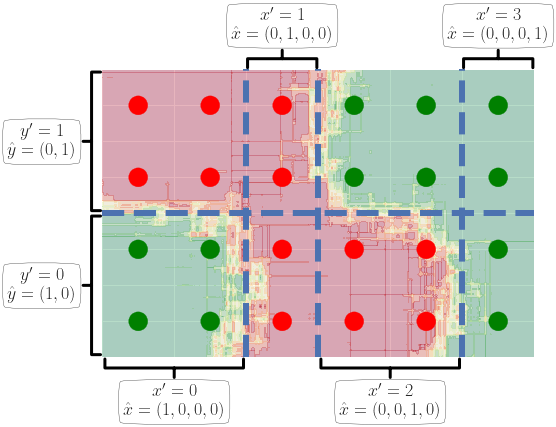

In [10]:
fig = plt.figure()  # figsize=(6, 4) # (7, 4)
ax = fig.add_axes((0, 0, 1, 1))

# plot
cs = plt.contourf(grid_xx, grid_yy, grid_prediction,
                  vmin=0, vmax=1, alpha=0.3,
                  cmap=plt.cm.RdYlGn.reversed())  # Spectral
# cbar = plt.colorbar(cs, ticks=[0, .2, .4, .6, .8, 1])

# plt.pcolormesh(grid_xx, grid_yy, grid_prediction)
#                cmap=plt.cm.Spectral)

plt.scatter(X[:, 0], X[:, 1], c=y, s=360)

# y
_line = plt.plot([0, 6], [2, 2], linewidth=6, linestyle='--')
_line_colour = _line[0].get_color()

# x
plt.plot([2, 2], [0, 4], linewidth=6, linestyle='--', c=_line_colour)
plt.plot([3, 3], [0, 4], linewidth=6, linestyle='--', c=_line_colour)
plt.plot([5, 5], [0, 4], linewidth=6, linestyle='--', c=_line_colour)

plt.xlim([0, 6])
plt.ylim([0, 4])

plt.tick_params(axis='both',
                which='both',
                bottom=False,
                labelbottom=False,
                left=False,
                labelleft=False)

# annotation
assert len(fig.axes) == 1
ax = fig.axes[0]
fontsize = 12
anot_x = '''\(x^\prime={xp:d}\)\n\(\hat{{x}}=({xh1:d},{xh2:d},{xh3:d},{xh4:d})\)'''
anot_y = '''\(y^\prime={yp:d}\)\n\(\hat{{y}}=({yh1:d},{yh2:d})\)'''
params = dict(
    xycoords='axes fraction', 
    fontsize=fontsize * 1.5,
    ma='center',
    bbox=dict(boxstyle='round4', fc='white', ec='black')
)
params_x_top = dict(
    arrowprops=dict(arrowstyle='-[, widthB=3.85, lengthB=.5', lw=3.0),
    ha='center',
    va='top'
)
params_x_bottom = dict(
    arrowprops=dict(arrowstyle='-[, widthB=1.925, lengthB=.5', lw=3.0),
    ha='center',
    va='bottom'
)
params_y = dict(
    arrowprops=dict(arrowstyle='-[, widthB=3.85, lengthB=.5', lw=3.0),
    ha='right',
    va='center'
)

# x-axis
ax.annotate(anot_x.format(xp=0, xh1=1, xh2=0, xh3=0, xh4=0),
            xy=(1 / 6, 0 - (.02 * 3 / 2)),
            xytext=(1 / 6, 0 - (.06 * 3 / 2)),
            **params, **params_x_top)
ax.annotate(anot_x.format(xp=2, xh1=0, xh2=0, xh3=1, xh4=0),
            xy=(4 / 6, 0 - (.02 * 3 / 2)),
            xytext=(4 / 6, 0 - (.06 * 3 / 2)),
            **params, **params_x_top)
ax.annotate(anot_x.format(xp=1, xh1=0, xh2=1, xh3=0, xh4=0),
            xy=(5 / 12, 1 + (.02 * 3 / 2)),
            xytext=(5 / 12, 1 + (.06 * 3 / 2)),
            **params, **params_x_bottom)
ax.annotate(anot_x.format(xp=3, xh1=0, xh2=0, xh3=0, xh4=1),
            xy=(11 / 12, 1 + (.02 * 3 / 2)),
            xytext=(11 / 12, 1 + (.06 * 3 / 2)),
            **params, **params_x_bottom)

# y-axis
ax.annotate(anot_y.format(yp=0, yh1=1, yh2=0),
            xy=(-0.02, 1 / 4),
            xytext=(-.06, 1 / 4),
            **params, **params_y)
ax.annotate(anot_y.format(yp=1, yh1=0, yh2=1),
            xy=(-0.02, 3 / 4),
            xytext=(-.06, 3 / 4),
            **params, **params_y)

# plt.tight_layout()
plt.savefig('_figures/discretisation_class_annotated.pdf',
            transparent=True, dpi=300, bbox_inches='tight')

### Interpretable Representation ###

In [11]:
X_c = np.array([
    [0, 0],
    [0, 1],
    [0, 2],
    [1, 0],
    [1, 2],
    [2, 0],
    [2, 1],
    [2, 2]
]) + 0.5

X_tl = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
    [1, 2],
    [2, 0],
    [2, 1],
    [2, 2]
]) + 0.5

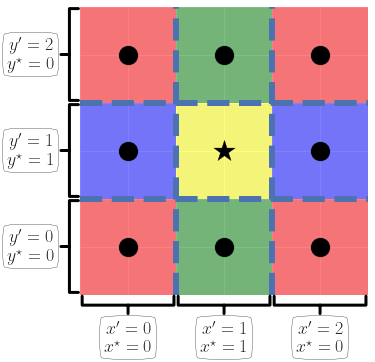

In [12]:
ANNOTATION_SUBSCRIPT = False

fig = plt.figure()  # figsize=(4, 4)
ax = fig.add_axes((0, 0, 1, 1))
ax.set_aspect('equal', 'box')

########## plot ########################
b_00, b_01, b_10, b_11 = [], [], [], []

b_00.append(Rectangle((0, 0), 1, 1))
b_00.append(Rectangle((2, 0), 1, 1))
b_00.append(Rectangle((0, 2), 1, 1))
b_00.append(Rectangle((2, 2), 1, 1))
pc_00 = PatchCollection(b_00, facecolor='red', alpha=0.5, edgecolor=None)
ax.add_collection(pc_00)

b_11.append(Rectangle((1, 1), 1, 1))
pc_11 = PatchCollection(b_11, facecolor='yellow', alpha=0.5, edgecolor=None)
ax.add_collection(pc_11)

b_01.append(Rectangle((1, 0), 1, 1))
b_01.append(Rectangle((1, 2), 1, 1))
pc_01 = PatchCollection(b_01, facecolor='green', alpha=0.5, edgecolor=None)
ax.add_collection(pc_01)

b_10.append(Rectangle((0, 1), 1, 1))
b_10.append(Rectangle((2, 1), 1, 1))
pc_10 = PatchCollection(b_10, facecolor='blue', alpha=0.5, edgecolor=None)
ax.add_collection(pc_10)
########################################

_scatter = plt.scatter(X_c[:, 0], X_c[:, 1], s=360, c='k')  # c=y
plt.scatter(1.5, 1.5, s=500, marker='*', c='k')  # _scatter.get_facecolors()

# y
_line = plt.plot([0, 3], [1, 1], linewidth=6, linestyle='--')
_line_colour = _line[0].get_color()
plt.plot([0, 3], [2, 2], linewidth=6, linestyle='--', c=_line_colour)

# x
plt.plot([1, 1], [0, 3], linewidth=6, linestyle='--', c=_line_colour)
plt.plot([2, 2], [0, 3], linewidth=6, linestyle='--', c=_line_colour)

plt.xlim([0, 3])
plt.ylim([0, 3])

plt.tick_params(axis='both',
                which='both',
                bottom=False,
                labelbottom=False,
                left=False,
                labelleft=False)

########## annotation ##################
assert len(fig.axes) == 1
ax = fig.axes[0]
fontsize = 12
if ANNOTATION_SUBSCRIPT:
    anot_x = '''\(x_1^\prime={xp:d}\)\n\(x_1^\star={xs:d}\)'''
    anot_y = '''\(x_2^\prime={yp:d}\)\n\(x_2^\star={ys:d}\)'''
else:
    anot_x = '''\(x^\prime={xp:d}\)\n\(x^\star={xs:d}\)'''
    anot_y = '''\(y^\prime={yp:d}\)\n\(y^\star={ys:d}\)'''
params = dict(
    xycoords='axes fraction', 
    fontsize=fontsize * 1.5,
    ma='center',
    bbox=dict(boxstyle='round4', fc='white', ec='black'),
    arrowprops=dict(arrowstyle='-[, widthB=2.55, lengthB=.5', lw=3.0)
)
params_x = dict(
    ha='center',
    va='top'
)
params_y = dict(
    ha='right',
    va='center'
)

# x-axis
ax.annotate(anot_x.format(xp=0, xs=0),
            xy=(1 / 6, 0 - (.02 * 3 / 2)),
            xytext=(1 / 6, 0 - (.06 * 3 / 2)),
            **params, **params_x)
ax.annotate(anot_x.format(xp=1, xs=1),
            xy=(3 / 6, 0 - (.02 * 3 / 2)),
            xytext=(3 / 6, 0 - (.06 * 3 / 2)),
            **params, **params_x)
ax.annotate(anot_x.format(xp=2, xs=0),
            xy=(5 / 6, 0 - (.02 * 3 / 2)),
            xytext=(5 / 6, 0 - (.06 * 3 / 2)),
            **params, **params_x)

# y-axis
ax.annotate(anot_y.format(yp=0, ys=0),
            xy=(0 - (.02 * 3 / 2), 1 / 6),
            xytext=(0 - (.06 * 3 / 2), 1 / 6),
            **params, **params_y)
ax.annotate(anot_y.format(yp=1, ys=1),
            xy=(0 - (.02 * 3 / 2), 3 / 6),
            xytext=(0 - (.06 * 3 / 2), 3 / 6),
            **params, **params_y)
ax.annotate(anot_y.format(yp=2, ys=0),
            xy=(0 - (.02 * 3 / 2), 5 / 6),
            xytext=(0 - (.06 * 3 / 2), 5 / 6),
            **params, **params_y)

fig.savefig('_figures/tabular_ir_centre.pdf',
            transparent=True, dpi=300, bbox_inches='tight')

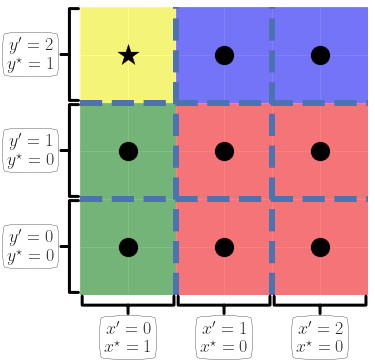

In [13]:
ANNOTATION_SUBSCRIPT = False

fig = plt.figure()  # figsize=(4, 4)
ax = fig.add_axes((0, 0, 1, 1))
ax.set_aspect('equal', 'box')

########## plot ########################
b_00, b_01, b_10, b_11 = [], [], [], []

b_00.append(Rectangle((1, 0), 1, 1))
b_00.append(Rectangle((1, 1), 1, 1))
b_00.append(Rectangle((2, 0), 1, 1))
b_00.append(Rectangle((2, 1), 1, 1))
pc_00 = PatchCollection(b_00, facecolor='red', alpha=0.5, edgecolor=None)
ax.add_collection(pc_00)

b_11.append(Rectangle((0, 2), 1, 1))
pc_11 = PatchCollection(b_11, facecolor='yellow', alpha=0.5, edgecolor=None)
ax.add_collection(pc_11)

b_01.append(Rectangle((1, 2), 1, 1))
b_01.append(Rectangle((2, 2), 1, 1))
pc_01 = PatchCollection(b_01, facecolor='blue', alpha=0.5, edgecolor=None)
ax.add_collection(pc_01)

b_10.append(Rectangle((0, 0), 1, 1))
b_10.append(Rectangle((0, 1), 1, 1))
pc_10 = PatchCollection(b_10, facecolor='green', alpha=0.5, edgecolor=None)
ax.add_collection(pc_10)
########################################

_scatter = plt.scatter(X_tl[:, 0], X_tl[:, 1], s=360, c='k')  # c=y
plt.scatter(0.5, 2.5, s=500, marker='*', c='k')  # _scatter.get_facecolors()

# y
_line = plt.plot([0, 3], [1, 1], linewidth=6, linestyle='--')
_line_colour = _line[0].get_color()
plt.plot([0, 3], [2, 2], linewidth=6, linestyle='--', c=_line_colour)

# x
plt.plot([1, 1], [0, 3], linewidth=6, linestyle='--', c=_line_colour)
plt.plot([2, 2], [0, 3], linewidth=6, linestyle='--', c=_line_colour)

plt.xlim([0, 3])
plt.ylim([0, 3])

plt.tick_params(axis='both',
                which='both',
                bottom=False,
                labelbottom=False,
                left=False,
                labelleft=False)

########## annotation ##################
assert len(fig.axes) == 1
ax = fig.axes[0]
fontsize = 12
if ANNOTATION_SUBSCRIPT:
    anot_x = '''\(x_1^\prime={xp:d}\)\n\(x_1^\star={xs:d}\)'''
    anot_y = '''\(x_2^\prime={yp:d}\)\n\(x_2^\star={ys:d}\)'''
else:
    anot_x = '''\(x^\prime={xp:d}\)\n\(x^\star={xs:d}\)'''
    anot_y = '''\(y^\prime={yp:d}\)\n\(y^\star={ys:d}\)'''
params = dict(
    xycoords='axes fraction', 
    fontsize=fontsize * 1.5,
    ma='center',
    bbox=dict(boxstyle='round4', fc='white', ec='black'),
    arrowprops=dict(arrowstyle='-[, widthB=2.55, lengthB=.5', lw=3.0)
)
params_x = dict(
    ha='center',
    va='top'
)
params_y = dict(
    ha='right',
    va='center'
)

# x-axis
ax.annotate(anot_x.format(xp=0, xs=1),
            xy=(1 / 6, 0 - (.02 * 3 / 2)),
            xytext=(1 / 6, 0 - (.06 * 3 / 2)),
            **params, **params_x)
ax.annotate(anot_x.format(xp=1, xs=0),
            xy=(3 / 6, 0 - (.02 * 3 / 2)),
            xytext=(3 / 6, 0 - (.06 * 3 / 2)),
            **params, **params_x)
ax.annotate(anot_x.format(xp=2, xs=0),
            xy=(5 / 6, 0 - (.02 * 3 / 2)),
            xytext=(5 / 6, 0 - (.06 * 3 / 2)),
            **params, **params_x)

# y-axis
ax.annotate(anot_y.format(yp=0, ys=0),
            xy=(0 - (.02 * 3 / 2), 1 / 6),
            xytext=(0 - (.06 * 3 / 2), 1 / 6),
            **params, **params_y)
ax.annotate(anot_y.format(yp=1, ys=0),
            xy=(0 - (.02 * 3 / 2), 3 / 6),
            xytext=(0 - (.06 * 3 / 2), 3 / 6),
            **params, **params_y)
ax.annotate(anot_y.format(yp=2, ys=1),
            xy=(0 - (.02 * 3 / 2), 5 / 6),
            xytext=(0 - (.06 * 3 / 2), 5 / 6),
            **params, **params_y)

fig.savefig('_figures/tabular_ir_top-left.pdf',
            transparent=True, dpi=300, bbox_inches='tight')

## Explanation Examples ##

In [14]:
moons_data, moons_target = sklearn.datasets.make_moons(
    n_samples=1000, noise=0.25, random_state=RANDOM_SEED)
moons_data = sklearn.preprocessing.MinMaxScaler(
    feature_range=(0, 1)).fit_transform(moons_data)

<Figure size 432x288 with 0 Axes>

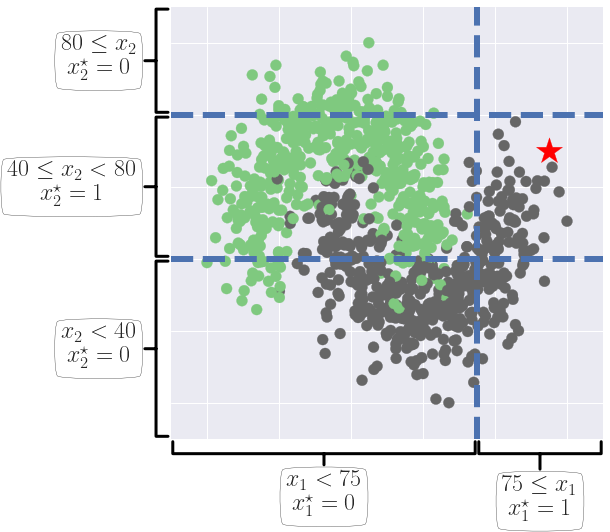

In [15]:
plt.set_cmap('Accent')
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes((0, 0, 1, 1))

plt.xlim([-.1, 1.1])
plt.ylim([-.1, 1.1])

plt.tick_params(axis='both',
                which='both',
                bottom=False,
                labelbottom=False,
                left=False,
                labelleft=False)

# plot
plt.scatter(moons_data[:, 0], moons_data[:, 1], c=moons_target, s=120)

_line = plt.plot([0.75, .75], [-0.1, 1.1], linewidth=6, linestyle='--')
_line_colour = _line[0].get_color()
plt.plot([-0.1, 1.1], [.8, .8], linewidth=6, linestyle='--', c=_line_colour)
plt.plot([-0.1, 1.1], [.4, .4], linewidth=6, linestyle='--', c=_line_colour)

plt.scatter(.95, .7, s=750, marker='*', c='r')  # _scatter.get_facecolors()

# annotations
assert len(fig.axes) == 1
assert fig.axes[0] is ax
fontsize = 12
params = dict(
    xycoords='axes fraction', 
    fontsize=fontsize * 2,
    ma='center',
    bbox=dict(boxstyle='round4', fc='white', ec='black')
)
params_x = dict(
    ha='center',
    va='top'
)
params_y = dict(
    ha='right',
    va='center'
)

# x-axis
ax.annotate('''\(x_1 < 75\)\n\(x_1^\star=0\)''',
            xy=(17 / 48, -.03),
            xytext=(17 / 48, -.08),
            arrowprops=dict(arrowstyle='-[, widthB=6.3, lengthB=.5', lw=3.0),
            **params, **params_x)
ax.annotate('''\(75 \leq x_1\)\n\(x_1^\star=1\)''',
            xy=(41 / 48, 0 - (.02 * 3 / 2)),
            xytext=(41 / 48, 0 - (.06 * 3 / 2)),
            arrowprops=dict(arrowstyle='-[, widthB=2.55, lengthB=.5', lw=3.0),
            **params, **params_x)

# y-axis
ax.annotate('''\(x_2 < 40\)\n\(x_2^\star=0\)''',
            xy=(-0.03, 10 / 48),
            xytext=(-.08, 10 / 48),
            arrowprops=dict(arrowstyle='-[, widthB=3.65, lengthB=.5', lw=3.0),
            **params, **params_y)
ax.annotate('''\(40 \leq x_2 < 80\)\n\(x_2^\star=1\)''',
            xy=(-0.03, 28 / 48),
            xytext=(-.08, 28 / 48),
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=.5', lw=3.0),
            **params, **params_y)
ax.annotate('''\(80 \leq x_2\)\n\(x_2^\star=0\)''',
            xy=(-0.03, 42 / 48),
            xytext=(-.08, 42 / 48),
            arrowprops=dict(arrowstyle='-[, widthB=2.15, lengthB=.5', lw=3.0),
            **params, **params_y)

plt.savefig('_figures/tabular_example.pdf',
            transparent=False, dpi=300, bbox_inches='tight')

In [16]:
explanation = [-0.65, 0.04]

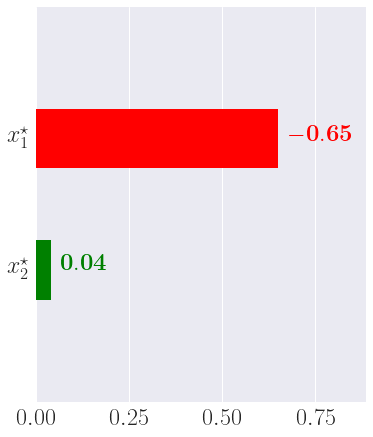

In [17]:
# xlim = (-0.001, 0.017) # (-0.01, 0.76)
# fontsize=14 # labelsize=16
plot_bar_exp(explanation, '_figures/tabular_explanation.pdf',
             label_fmt='\\(x_{{{:d}}}^\star\\)',
             onesided=True)